<a href="https://colab.research.google.com/github/miamackk/simple-world/blob/main/HW2_McCarthy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 2: Simple World and Linear Algebra Practice

## Import the necessary dependencies

In [ ]:
# Ignore the pip dependency error

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2d
import scipy.sparse as sps
from PIL import Image

# # Package for fast equation solving
from sys import platform
print(platform)
if platform == "linux" or platform == "linux2":
    ! apt-get install libsuitesparse-dev
elif platform == "darwin":
    ! brew install suite-sparse

! pip3 install sparseqr
import sparseqr

linux
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2
  librbio2 libsliplu1 libspqr2 libsuitesparseconfig5 libumfpack5
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2
  librbio2 libsliplu1 libspqr2 libsuitesparse-dev libsuitesparseconfig5
  libumfpack5
0 upgraded, 19 newly installed, 0 to remove and 1 not upgraded.
Need to get 22.4 MB of archives.
After this operation, 169 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd6

In [ ]:
# Get images for plots (images are also included in the folder)
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img1.png
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img2.png
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img3.png
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img4.png
! wget http://6.869.csail.mit.edu/sp23/pset1/pset_1_reference.png

--2025-12-18 02:05:29--  http://6.869.csail.mit.edu/fa19/psets19/pset1/img1.png
Resolving 6.869.csail.mit.edu (6.869.csail.mit.edu)... 128.30.100.221
Connecting to 6.869.csail.mit.edu (6.869.csail.mit.edu)|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96264 (94K) [image/png]
Saving to: ‘img1.png’

img1.png            100%[===================>]  94.01K  --.-KB/s    in 0.1s    

2025-12-18 02:05:29 (866 KB/s) - ‘img1.png’ saved [96264/96264]

--2025-12-18 02:05:30--  http://6.869.csail.mit.edu/fa19/psets19/pset1/img2.png
Resolving 6.869.csail.mit.edu (6.869.csail.mit.edu)... 128.30.100.221
Connecting to 6.869.csail.mit.edu (6.869.csail.mit.edu)|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76847 (75K) [image/png]
Saving to: ‘img2.png’

img2.png            100%[===================>]  75.05K  --.-KB/s    in 0.1s    

2025-12-18 02:05:30 (692 KB/s) - ‘img2.png’ saved [76847/76847]

--2025-12-18 02:05:30--  h

## Define the Sparse Matrix

In [ ]:
def sparseMatrix(i, j, Aij, imsize):
    """ Build a sparse matrix containing 2D linear neighborhood operators
    Input:
        Aij = [ni, nj, nc] nc: number of neighborhoods with contraints
        i: row index
        j: column index
        imsize: [nrows ncols]
    Returns:
        A: a sparse matrix. Each row contains one 2D linear operator
    """
    ni, nj, nc = Aij.shape
    nij = ni*nj

    a = np.zeros((nc*nij))
    m = np.zeros((nc*nij))
    n = np.zeros((nc*nij))
    grid_range = np.arange(-(ni-1)/2, 1+(ni-1)/2)
    jj, ii = np.meshgrid(grid_range, grid_range)
    ii = ii.reshape(-1,order='F')
    jj = jj.reshape(-1,order='F')


    k = 0
    for c in range(nc):
        # Get matrix index
        x = (i[c]+ii) + (j[c]+jj)*nrows
        a[k:k+nij] = Aij[:,:,c].reshape(-1,order='F')
        m[k:k+nij] = c
        n[k:k+nij] = x

        k += nij

    m = m.astype(np.int32)
    n = n.astype(np.int32)
    A = sps.csr_matrix((a, (m,  n)))

    return A

## Define world parameters and plot the edges

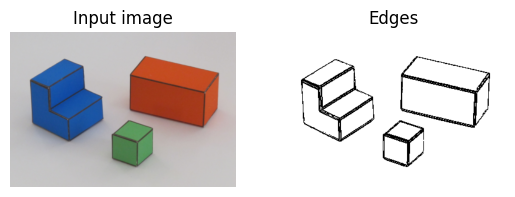

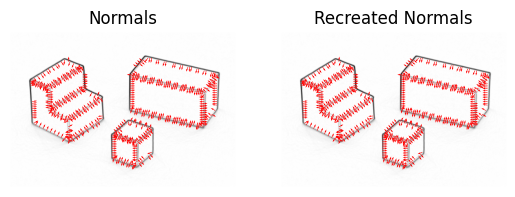

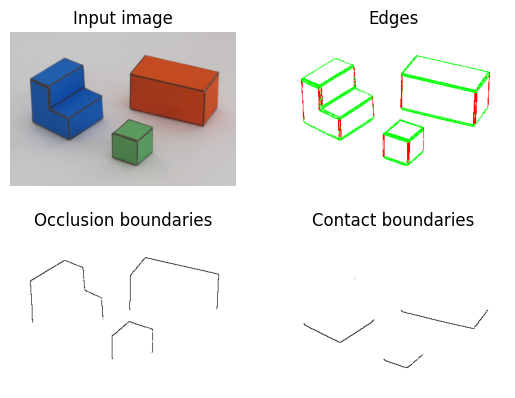

In [ ]:
theta = 9*math.pi/180;

img = cv2.imread('img1.png')
img = img[:, :, ::-1].astype(np.float32)

nrows, ncols, colors = img.shape
ground = (np.min(img, axis=2) > 110).astype(np.float32)
# print('ground', ground.shape, ground)
foreground = (ground == 0).astype(np.float32)

m = np.mean(img, 2)
kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
dmdx = conv2d(m, kern, 'same')
dmdy = conv2d(m, kern.transpose(), 'same')

mag = np.sqrt(dmdx**2 + dmdy**2)
mag[0, :] = 0
mag[-1, :] = 0
mag[:, 0] = 0
mag[:, -1] = 0

edges = mag >= 30
edges = edges * foreground

## Occlusion and contact edges

####################################################################
### COMPLETE THE CODE BELOW (TODOs) AND COPY IT INTO YOUR REPORT ###
####################################################################

pi = math.pi
edge_orientation = np.arctan2(dmdy, dmdx)


vertical_mask = np.logical_or((np.abs(edge_orientation) <= theta) , (np.abs(edge_orientation) >= (pi-theta)))
horizontal_mask = np.logical_and((np.abs(edge_orientation) > theta),(np.abs(edge_orientation) < (pi-theta)))

vertical_edges = edges * vertical_mask
horizontal_edges = edges * horizontal_mask

####################################################################
###################### STOP COPYING HERE ###########################
####################################################################

kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
horizontal_ground_to_foreground_edges = (conv2d(ground, kern, 'same'))>0;
horizontal_foreground_to_ground_edges = (conv2d(foreground, kern, 'same'))>0;
vertical_ground_to_foreground_edges = vertical_edges*np.abs(conv2d(ground, kern.transpose(), 'same'))>0


occlusion_edges = edges*(vertical_ground_to_foreground_edges + horizontal_ground_to_foreground_edges)
contact_edges   = horizontal_edges*(horizontal_foreground_to_ground_edges);


E = np.concatenate([vertical_edges[:,:,None],
                    horizontal_edges[:,:,None],
                    np.zeros(occlusion_edges.shape)[:,:,None]], 2)

# Plot
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')
plt.subplot(2,2,2)
plt.imshow(edges == 0, cmap='gray')
plt.axis('off')
plt.title('Edges')

# Normals
K = 3
ey, ex = np.where(edges[::K, ::K])
ex *= K
ey *= K
plt.figure()
plt.subplot(2,2,3)
plt.imshow(np.max(mag)-mag, cmap='gray')
dxe = dmdx[::K, ::K][edges[::K, ::K] > 0]
dye = dmdy[::K, ::K][edges[::K, ::K] > 0]
n = np.sqrt(dxe**2 + dye**2)
dxe = dxe/n
dye = dye/n
plt.quiver(ex, ey, dxe, -dye, color='r')
plt.axis('off')
plt.title('Normals')


plt.subplot(2,2,4)
plt.imshow(np.max(mag)-mag, cmap='gray')
# Recreate the normals plot using sin and cos
# Note: -dye_mod  used in plot because 0 is upper right corner here
dxe_mod = nx = np.cos(edge_orientation[::K, ::K][edges[::K, ::K] > 0])
dye_mod = ny = np.sin(edge_orientation[::K, ::K][edges[::K, ::K] > 0])
plt.quiver(ex, ey, dxe_mod, -dye_mod, color='r') # at ex, ey location, plot dx, -dy
plt.axis('off')
plt.title('Recreated Normals')
plt.show()


# Edges and boundaries
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')


plt.subplot(2,2,2)
plt.imshow(E+(edges == 0)[:, :, None])
plt.axis('off')
plt.title('Edges')


plt.subplot(2,2,3)
plt.imshow(1-(occlusion_edges>0), cmap='gray')
plt.axis('off')
plt.title('Occlusion boundaries')

plt.subplot(2,2,4)
plt.imshow(1-contact_edges, cmap='gray')
plt.axis('off')
plt.title('Contact boundaries');

In [ ]:
print(dmdx[0][0],dmdy[0][0])
print(np.arctan(dmdy[0][0]/dmdx[0][0]))
print(edge_orientation[0][0])


-590.3334 -592.3334
0.7870893
-2.3545034


## Populate edge variables


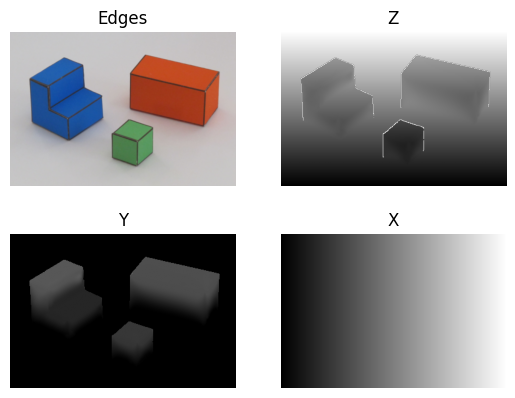

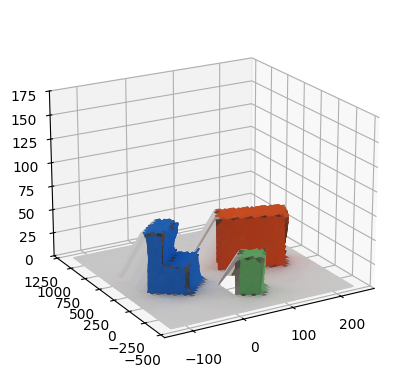

In [ ]:
Nconstraints = nrows*ncols*20
Aij = np.zeros((3, 3, Nconstraints))
b = np.zeros((Nconstraints, 1))

#Indices and counters
ii = np.zeros((Nconstraints, 1))
jj = np.zeros((Nconstraints, 1))
global c
c = 0

# These will always be updated with the current indices
def update_indices():
  global c
  ii[c] = i
  jj[c] = j
  c += 1

# Create linear contraints
for i in range(1, nrows-1):
  for j in range(1, ncols-1):
    # Y = 0
    if ground[i,j]:
      Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
      b[c]       = 0
      update_indices()
    else:
      # Check if current neighborhood touches an edge
      edgesum = np.sum(edges[i-1:i+2,j-1:j+2])
      # Check if current neighborhood touches ground pixels
      groundsum = np.sum(ground[i-1:i+2,j-1:j+2])
      # Check if current neighborhood touches vertical pixels
      verticalsum = np.sum(vertical_edges[i-1:i+2,j-1:j+2])
      # Check if current neighborhood touches horizontal pixels
      horizontalsum = np.sum(horizontal_edges[i-1:i+2,j-1:j+2])

      ####################################################################
      ### COMPLETE THE CODE BELOW (TODOs) AND COPY IT INTO YOUR REPORT ###
      ####################################################################

      # TODO: edge orientation (average of edge pixels in current neighborhood)
      # Populate Aij, ii, jj, b, and c using theta, edge_orientation, and
      # the constraint/transform matrices you derived in the written segment

      # Contact edge: Y = 0
      # Requires: a transform matrix
      # TODO: Complete the code
      if contact_edges[i, j]:
        Aij[:,:,c] = np.array([[0,0,0],[0, 1, 0],[0,0,0]])
        b[c]       = 0
        update_indices()

      # Vertical edge: dY/dy = 1/cos(theta)
      # Requires: a transform matrix, theta
      # The 1/8 is for normalization
      # TODO: Complete the code
      if verticalsum > 0 and groundsum == 0:
        Aij[:,:,c] = (1/8 )* np.array([[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]])
        b[c]       = 1/np.cos(theta)
        update_indices()

      # Horizontal edge: dY/dt = 0
      # Note: You'll have to express t using other variables
      # Requires: a transform matrix, i, j, edge_orientation
      # TODO: Complete the code

      if horizontalsum > 0 and groundsum == 0 and verticalsum == 0:
        n_x, n_y = dmdx/edgesum, dmdy/edgesum

        Aij[:,:,c] = (1/8) * (-n_y[i,j] * np.array([[-1, 0, 1],
                                                    [-2, 0, 2],
                                                    [-1, 0, 1]])
                            + n_x[i,j] * np.array([[-1, -2,-1],
                                                   [0, 0, 0],
                                                   [1, 2, 1]]))
        b[c]       = 0
        update_indices()

      # Second derivative = 0 (weighted by 0.1 to reduce constraint strength)
      # Requires: multiple transform matrices
      # TODO: Complete the code
      if groundsum == 0:
        Aij[:,:,c] = (0.1) * np.array([[0, 0, 0],
                                       [-1, 2, -1],
                                       [0, 0, 0]])
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = (0.1) * np.array([[0,-1,0],
                                       [0,2,0],
                                       [0,-1,0]])
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = (0.1) * np.array([[0, -1, 1],
                                       [0, 1, -1],
                                       [0, 0, 0]])
        b[c]       = 0
        update_indices()

      ####################################################################
      ###################### STOP COPYING HERE ###########################
      ####################################################################

# Solve for constraints
ii = ii[:c]
jj = jj[:c]
Aij = Aij[:,:,:c]
b = b[:c]
A = sparseMatrix(ii, jj, Aij, nrows)
Y = sparseqr.solve( A, b)

# Transform vector into image
Y = np.reshape(Y, [nrows, ncols], order='F')

# Recover 3D world coordinates
x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
x = x.astype(np.float32)
y = y.astype(np.float32)
x -= nrows/2
y -= ncols/2

# Final coordinates
X = x
Z = Y*np.cos(theta)/np.sin(theta) - y/np.sin(theta)
Y = -Y
Y = np.maximum(Y, 0);

E = occlusion_edges.astype(np.float32);
E[E > 0] = np.nan;
Z = Z+E; #  remove occluded edges

# Visualize solution
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img[1:-1, 1:-1].astype(np.uint8))
plt.axis('off')
plt.title('Edges')

plt.subplot(2,2,2)
plt.imshow(Z[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Z')


plt.subplot(2,2,3)
plt.imshow(Y[1:-1, 1:-1], cmap='gray', vmin=0, vmax=175)
plt.axis('off')
plt.title('Y')

plt.subplot(2,2,4)
plt.imshow(X[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('X')

# 3D projection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(0, 175)

# TODO for Problem 5
# Rerun the script with at least two more of the provided images and for each
# image try at least two different view angles.
# Include the generated plots in your report (under Problem 5).
# Note that we expect results to be quite brittle -- in answering Problem 6,
# think about the strong assumptions that this approach makes.
# We'll see more robust methods for similar problems later in the course

# Specify here the angle you want to see
ax.view_init(20, -120)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

### Reference solution
Yours should render on a white background (note that the outline on Z is transparency) but be identical otherwise

**Uploading the reference will be considered an honor code violation**

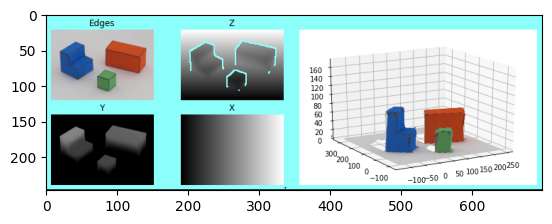

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread('pset_1_reference.png'), cv2.COLOR_BGR2RGB))
plt.show()